## Sentiment Analysis

In [1]:
import pandas as pd
import numpy as np

#NLTK
import nltk
from nltk import word_tokenize, WordPunctTokenizer, regexp_tokenize
from nltk import word_tokenize, WordPunctTokenizer, regexp_tokenize

#Plotting 
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

#Keras
from numpy import array
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding

# Import Data

In [2]:
import xml.etree.ElementTree as ET
tree = ET.parse('DATA/general-Tweet.xml')
root = tree.getroot()

In [3]:
train_set = pd.DataFrame({'tweet_id':[],'tweetText':[],'polarity_value':[],'polarity_type':[],'topic':[]})
row=0
for tweet in root:
    tweet_id = 'ID:'+tweet.find('tweetid').text
    #user = tweet.find('user').text
    tweetText = tweet.find('content').text
    lang = tweet.find('lang').text
    polarity_value = tweet.find('sentiments').find('polarity').find('value').text
    polarity_type = tweet.find('sentiments').find('polarity').find('type').text
    topic = tweet.find('topics').find('topic').text
    
    if lang == 'es':
        train_set.loc[row] = [tweet_id,tweetText,polarity_value,polarity_type,topic]
        row+=1

In [4]:
train_set['set'] = 'train'
train_set.head(10)

,tweet_id,tweetText,polarity_value,polarity_type,topic,set
0,ID:142389495503925248,"Salgo de #VeoTV , que día más largoooooo...",NONE,AGREEMENT,otros,train
1,ID:142389933619945473,@PauladeLasHeras No te libraras de ayudar me/n...,NEU,DISAGREEMENT,otros,train
2,ID:142391947707940864,@marodriguezb Gracias MAR,P,AGREEMENT,otros,train
3,ID:142416095012339712,"Off pensando en el regalito Sinde, la que se v...",N,AGREEMENT,política,train
4,ID:142422495721562112,Conozco a alguien q es adicto al drama! Ja ja ...,P,AGREEMENT,otros,train
5,ID:142424715175280640,"RT @FabHddzC: Si amas a alguien, déjalo libre....",NONE,AGREEMENT,música,train
6,ID:142483342040907776,Toca @crackoviadeTV3 . Grabación dl especial N...,P,AGREEMENT,entretenimiento,train
7,ID:142493511634259968,Hoy asisitiré en Madrid a un seminario sobre l...,NONE,AGREEMENT,política,train
8,ID:142494476051562496,Buen día todos! Lo primero mandar un abrazo gr...,P,AGREEMENT,otros,train
9,ID:142496796416016384,Desde el escaño. Todo listo para empezar #endi...,P,AGREEMENT,política,train


In [5]:
#Rename columns
train_set.columns = ['tweet_id', 'tweetText', 'polarity_value', 'polarity_type', 'topic','set']
train_set.head(4)

,tweet_id,tweetText,polarity_value,polarity_type,topic,set
0,ID:142389495503925248,"Salgo de #VeoTV , que día más largoooooo...",NONE,AGREEMENT,otros,train
1,ID:142389933619945473,@PauladeLasHeras No te libraras de ayudar me/n...,NEU,DISAGREEMENT,otros,train
2,ID:142391947707940864,@marodriguezb Gracias MAR,P,AGREEMENT,otros,train
3,ID:142416095012339712,"Off pensando en el regalito Sinde, la que se v...",N,AGREEMENT,política,train


In [6]:
train_set.tweetText[0]

'Salgo de #VeoTV , que día más largoooooo...'

In [7]:
train_set.topic.value_counts()

política           2715
otros              1620
entretenimiento    1209
economía            525
música              412
fútbol              225
cine                183
tecnología          144
deportes            101
literatura           84
Name: topic, dtype: int64

In [8]:
train_set.polarity_value.value_counts()

P       2884
N       2182
NONE    1482
NEU      670
Name: polarity_value, dtype: int64

#### Let's keep only the positive and negative tweets

In [9]:
train_set = train_set.loc[(train_set.polarity_value == 'P') | (train_set.polarity_value == 'N') ]
train_set.polarity_value.value_counts()

P    2884
N    2182
Name: polarity_value, dtype: int64

# Colombian Tweets mentioning candidates

In [10]:
tweets = pd.read_csv('tweets_mentioning_candidates.csv')
tweets['set'] = 'test'
tweets['polarity_value'] = np.NaN
tweets.shape

(30000, 18)

# Processing Tweets

Merge both datasets for pre-processing.

In [11]:
processed_tweets= pd.concat([pd.DataFrame({'tweetID':tweets.tweetID, 'tweetText':tweets.tweetText,'polarity_value':tweets.polarity_value, 'set':tweets.set}), 
                             pd.DataFrame({'tweetID':train_set.tweet_id, 'tweetText':train_set.tweetText, 'polarity_value':train_set.polarity_value,'set':train_set.set})], ignore_index=True)
processed_tweets['processed_tweet'] = processed_tweets.tweetText
processed_tweets.sample(4)

,tweetID,tweetText,polarity_value,set,processed_tweet
30922,ID:151378281772490753,"Intentemos disfrutar, al margen de todo esto.",P,train,"Intentemos disfrutar, al margen de todo esto."
7087,ID:1008500006595252225,Espero que calle bocas el candidato de centro ...,NaN,test,Espero que calle bocas el candidato de centro ...
32734,ID:167750882333696000,"No se donde tengo las llaves, ni la agenda ni ...",N,train,"No se donde tengo las llaves, ni la agenda ni ..."
29985,ID:1008486856529448962,@lasillaenvivo @petrogustavo @AngelicaLozanoC ...,NaN,test,@lasillaenvivo @petrogustavo @AngelicaLozanoC ...


### Change Hashtags to __HASH_

In [12]:
import re
hash_regex = re.compile(r"#(\w+)")
hstgs = [] 
def hash_repl(match):
    _ = '__HASH_'+match.group(1).upper()
    hstgs.append(_)
    return _

###  Change Usernames to __user_

In [13]:
user_regex = re.compile(r"@(\w+)")
usr_names = [] 
def user_repl(match):
    _ = '__user_'+match.group(1).upper()
    usr_names.append(_)
    return _

###  Change URLs to __URL_

In [14]:
url_regex = re.compile(r"(http|https|ftp)://[a-zA-Z0-9\./]+")
def url_repl(match):
    return '__URL_'

### Repetitions

In [15]:
# Repeating words like Aloooooooha
rpt_regex = re.compile(r"(.)\1{1,}", re.IGNORECASE);
def rpt_repl(match):
    return match.group(1)+match.group(1)

In [16]:
# Test
re.sub(rpt_regex, rpt_repl, "Repeeeeeeeeeeated characters in wordddddddddds" )

'Repeeated characters in wordds'

### Punctuation

In [17]:
word_bound_regex = re.compile(r"\W+")
punctuations = \
	[	#('',		['.', ] )	,\
		#('',		[',', ] )	,\
		#('',		['\'', '\"', ] )	,\
		('__PUNC_EXCL',		['!', '¡', ] )	,\
		('__PUNC_QUES',		['?', '¿', ] )	,\
		('__PUNC_ELLP',		['...', '…', ] )	,\
	]
def punctuations_repl(match):
	text = match.group(0)
	repl = []
	for (key, parr) in punctuations :
		for punc in parr :
			if punc in text:
				repl.append(key)
	if( len(repl)>0 ) :
		return ' '+' '.join(repl)+' '
	else :
		return ' '

### Stemming
there is no spanish language for PorterStemmer, we use snowball!

In [18]:
from nltk.stem import SnowballStemmer
stemmer = SnowballStemmer('spanish')

In [19]:
# Test
text = processed_tweets.processed_tweet[55]
print(text)
text = [word if(word[0:2]=='__') else word.lower() for word in text.split() if ((len(word) >= 3) and (word not in usr_names))]
text = [stemmer.stem(w) for w in text]                
text = " ".join(text)
print('------------------')
print(text)

@IvanDuque Presidente, desde ya bendiciones ! Me gustaría trabajar al lado suyo. Bendiciones y sabiduría !
------------------
@ivanduqu presidente, desd bendicion gust trabaj lad suyo. bendicion sabidur


In [20]:
def sb_stem(text, only_first=0):
    text = [word if(word[0:2]=='__') else word.lower() for word in text.split() if ((len(word) >= 3) or (word in ['no','si', 'sí', 'ni']))] #   If we are doing negation analysis, maybe is a better idea to keep the small words (like 'no')
    text = [stemmer.stem(w) if w[0:2]!='__' else w for w in text ]
    
    return(text)

In [21]:
def processAll(text):
    text = re.sub( hash_regex, hash_repl, text )
    text = re.sub( user_regex, user_repl, text)
    text = re.sub( url_regex, url_repl, text )
    text = text.replace('\'','')
    text = re.sub( word_bound_regex , punctuations_repl, text )
    text = re.sub( rpt_regex, rpt_repl, text )
    text = sb_stem(text)    
    return text

### Process tweets

In [22]:
processed_tweets['processed_tweet'] = processed_tweets.tweetText.apply(processAll)
#check
processed_tweets.sample(4)

,tweetID,tweetText,polarity_value,set,processed_tweet
14652,ID:1008495554307948549,@petrogustavo Duque es su presidente,NaN,test,"[__user_PETROGUSTAVO, duqu, president]"
5221,ID:1008501365012869120,"Sí se pudo, sí se pudo @IvanDuque",NaN,test,"[pud, si, pud, __user_IVANDUQUE]"
4198,ID:1008502015171989505,"""No mas divisiones, pensemos en un país con t...",NaN,test,"[mas, division, pens, pais, con, tod, par, tod..."
16588,ID:1008494426669318145,Estoy a punto de llorar escuchando el discurso...,NaN,test,"[estoy, punt, llor, escuch, discurs, petr, ust..."


### Emoticons

In [23]:
# Emoticons
emoticons = \
	[	# For __EMOT_SMILEY
        (' __emoji: U+1F601',	[':-)', ':)', '(:', '(-:', ] )	,\
        # for __EMOT_LAUGH
		(' __emoji: U+1F923',		[':-D', ':D', 'X-D', 'XD', 'xD', ] )	,\
        # For __EMOT_LOVE
		(' __emoji: U+2764',		['<3', ':\*', ] )	,\
        # For __EMOT_WINK
		('__emoji: U+1F609',		[';-)', ';)', ';-D', ';D', '(;', '(-;', ] )	,\
        # For __EMOT_FROWN
		(' __emoji: U+2639',		[':-(', ':(', '(:', '(-:', ] )	,\
        # For __EMOT_CRY
		(' __emoji: U+1F622',		[':,(', ':\'(', ':"(', ':(('] )	,\
	]
def escape_paren(arr):
	return [text.replace(')', '[)}\]]').replace('(', '[({\[]') for text in arr]
def regex_union(arr):
	return '(' + '|'.join( arr ) + ')'
emoticons_regex = [ (repl, re.compile(regex_union(escape_paren(regx))) ) for (repl, regx) in emoticons ]

In [24]:
# Test
text = "This is a text with one emoticon :) and another :("
for (repl, regx) in emoticons_regex :
    text = re.sub(regx, ' '+repl+' ', text)
    
print(text)

This is a text with one emoticon   __emoji: U+1F601  and another   __emoji: U+2639 


We will translate them to their respective  unicode values:

In [25]:
emojis_db=pd.read_csv('emojis_db_csv.csv')
emojis_db.head()
emojis_db.emoji_category.unique()

array(['face-positive', 'face-neutral', 'face-negative', 'face-sick',
       'face-role', 'face-fantasy', 'cat-face', 'monkey-face', 'person',
       'person-role', 'person-fantasy', 'person-gesture',
       'person-activity', 'person-sport', 'family', 'body', 'hair-style',
       'emotion', 'clothing', 'animal-mammal', 'animal-bird',
       'animal-amphibian', 'animal-reptile', 'animal-marine',
       'animal-bug', 'plant-flower', 'plant-other', 'food-fruit',
       'food-vegetable', 'food-prepared', 'food-asian', 'food-sweet',
       'drink', 'dishware', 'place-map', 'place-geographic',
       'place-building', 'place-religious', 'place-other',
       'transport-ground', 'transport-water', 'transport-air', 'hotel',
       'time', 'sky & weather', 'event', 'award-medal', 'sport', 'game',
       'arts & crafts', 'sound', 'music', 'musical-instrument', 'phone',
       'computer', 'light & video', 'book-paper', 'money', 'mail',
       'writing', 'office', 'lock', 'tool', 'science', 'medi

In [26]:
def emojis_unicode(tweet):
    ''' Extracts the emojis on the tweet on Unicode format, also tries to match those in regular format, such as ";)" '''
    for (repl, regx) in emoticons_regex :
        tweet = re.sub(regx, ' '+repl+' ', tweet)
    tweet_unicode = str(tweet.encode('unicode-escape'))
    tweet_unicode = tweet_unicode.replace('\\\\U000',' __emoji: U+')    
    emoji_list = []
    for emoji in range(tweet_unicode.count(' __emoji: ')):
        em = tweet_unicode.split('__emoji: ')[emoji+1].split()[0]
        em = em[:7]
        emoji_list.append(em.upper())
    return emoji_list

In [27]:
# Test
text = "This is a text with one emoticon :) and another :( and some others: 😡 🤣😂"
emojis_unicode(text)

['U+1F601', 'U+2639', 'U+1F621', 'U+1F923', 'U+1F602']

Now we can get the category of the extracted emojis

In [28]:
def emoji_category(emojis):
    categories = []
    for i in range(len(emojis)):
        # print(emojis[i])
        try:
            categories.append(emojis_db.loc[emojis_db.code == emojis[i]].emoji_category.values[0])
        except:
            try:
                _ = emojis[i].split('+')[1] + '+'
                categories.append(emojis_db[emojis_db.code.str.contains(_)].emoji_category.values[0])
            except:
                categories.append('other')
    if len(categories) < 1:
        categories.append('no_emojis')
    return categories

emoji_category(emojis_unicode(text))

['face-positive',
 'face-negative',
 'face-negative',
 'face-positive',
 'face-positive']

In [29]:
processed_tweets.head(6)

,tweetID,tweetText,polarity_value,set,processed_tweet
0,ID:1008504539916455936,Lo mejor del discurso de @IvanDuque es cuando ...,NaN,test,"[mejor, del, discurs, __user_IVANDUQUE, cuand,..."
1,ID:1008504538981191680,@manuelrosalesg @IvanDuque @mluciaramirez Los ...,NaN,test,"[__user_MANUELROSALESG, __user_IVANDUQUE, __us..."
2,ID:1008504538242977792,@gloserna @fransupelano @icolombianoo @AlvaroU...,NaN,test,"[__user_GLOSERNA, __user_FRANSUPELANO, __user_..."
3,ID:1008504536208683013,@_El_Patriota @petrogustavo @JSantrich_FARC Pa...,NaN,test,"[__user__EL_PATRIOTA, __user_PETROGUSTAVO, __u..."
4,ID:1008504534371635201,Que diferencia de discursos! Gracias @IvanDuque,NaN,test,"[que, diferent, discurs, __PUNC_EXCL, graci, _..."
5,ID:1008504534317101056,Felicidades al nuevo presidente de #Colombia @...,NaN,test,"[felic, nuev, president, __HASH_COLOMBIA, __us..."


### N-grams

In [30]:
# Unigrams
unigrams_fd = nltk.FreqDist()
bi_grams_fd = nltk.FreqDist()
tri_grams_fd = nltk.FreqDist()

def get_word_features(words):
    bag = {}
    words_uni = [ 'has(%s)'% ug for ug in words ]
    words_bi  = [ 'has(%s)'% ','.join(map(str,bg)) for bg in nltk.bigrams(words) ]
    words_tri = [ 'has(%s)'% ','.join(map(str,tg)) for tg in nltk.trigrams(words) ]
    
    for f in words_uni+words_bi+words_tri:
        bag[f] = 1

    return bag

### Negation

In [31]:
sb_stem('nunca no nada ningún ninguno ninguna tampoco')
negtn_regex = re.compile( r"""(?:
    ^(?:nunca|no|nada|ningún|ninguno|ninguna|tampoco|
        nunc|nad|ningun|tampoc
    )$
)
|
n't
""", re.X)

def get_negation_features(words):
    INF = 0.0
    negtn = [ bool(negtn_regex.search(w)) for w in words ]

    left = [0.0] * len(words)
    prev = 0.0
    for i in range(0,len(words)):
        if( negtn[i] ):
            prev = 1.0
        left[i] = prev
        prev = max( 0.0, prev-0.1)

    right = [0.0] * len(words)
    prev = 0.0
    for i in reversed(range(0,len(words))):
        if( negtn[i] ):
            prev = 1.0
        right[i] = prev
        prev = max( 0.0, prev-0.1)

    return dict( zip(
                    ['neg_l('+w+')' for w in  words] + ['neg_r('+w+')' for w in  words],
                    left + right ) )

In [32]:
# Test
text = ["Este","tweet", "no", "es", "positivo"]
get_negation_features(text)

{'neg_l(Este)': 0.0,
 'neg_l(tweet)': 0.0,
 'neg_l(no)': 1.0,
 'neg_l(es)': 0.9,
 'neg_l(positivo)': 0.8,
 'neg_r(Este)': 0.8,
 'neg_r(tweet)': 0.9,
 'neg_r(no)': 1.0,
 'neg_r(es)': 0.0,
 'neg_r(positivo)': 0.0}

### Polarity

We tried using the spanish sentiment lexicon from http://www.opener-project.eu/ but it didn't improve the results on any of the algorithms. Maybe due to the fact that spanish from Spain is different from the spanish spoken in Colombia.

In [33]:
opener_lexicon = pd.read_csv('https://raw.githubusercontent.com/opener-project/public-sentiment-lexicons/master/propagation_lexicons/es/es.lemma.sy.an.hypo.rels.maxdepth5.seed500.maj.gold.csv', sep=';', header=None)
opener_lexicon.columns = ['x','pos', 'polarity', 'xx','word','xxx']
opener_lexicon.head()

,x,pos,polarity,xx,word,xxx
0,unknown,n,positive,1.0,felicitación,1
1,unknown,a,negative,1.0,inconsciente,1
2,unknown,n,neutral,1.0,soporte,1
3,unknown,n,neutral,1.0,proceso_matemático,1
4,unknown,v,positive,1.0,manifestar,1


In [34]:
def get_sent(polarity):
    if polarity == 'neutral':
        return 0
    if polarity == 'negative':
        return -1
    if polarity == 'positive':
        return 1
opener_lexicon['sentiment'] = opener_lexicon.polarity.apply(get_sent)

In [35]:
opener_lexicon['stmd_word'] = opener_lexicon['word'].apply(sb_stem)
opener_lexicon['stmd_word'] = opener_lexicon.stmd_word.apply(lambda x: str(x).replace('[','').replace(']','').replace("'",''))
opener_lexicon = opener_lexicon[['word','stmd_word','sentiment']]
opener_lexicon = opener_lexicon.loc[opener_lexicon.sentiment != 0]
opener_lexicon = opener_lexicon.drop_duplicates()
opener_lexicon.sample(4)

,word,stmd_word,sentiment
3982,regocijado,regocij,1.0
3690,Al_Capone,al_capon,-1.0
916,perder,perd,-1.0
12606,carta_de_flete,carta_de_flet,1.0


In [36]:
def get_polarity_features(text):
    pol = {}
    text = sb_stem(text)
    for word in text:
        try:
            pol["sent("+word+")"] = opener_lexicon.loc[opener_lexicon.stmd_word == word].sentiment.values[0]
        except:
            continue
            
    return pol

_ = processed_tweets.tweetText[1503]
print('Tweet ',_)
print('Would have the following words and sentiments associated:')
print(get_polarity_features(_))

Tweet  @OIZuluaga @IvanDuque Lo que se construye con la corrupción solo es del beneficio de unos pocos (Odebrecht)
Would have the following words and sentiments associated:
{'sent(sol)': 1.0, 'sent(benefici)': 1.0}


### Apply Features

In [37]:
# Wrapper function for the extraction of features
def extract_features(text):
    global usr_names, hstgs
    features = {}
    words = text
    words = processAll(text)
    word_features = get_word_features(words)
    features.update( word_features )
    negation_features = get_negation_features(words)
    features.update( negation_features )
    emoji_features = emoji_category(emojis_unicode(text))
    emoji_features_dic = dict( zip(['emoji_('+w+')' for w in  emoji_features], emoji_features))
    features.update( emoji_features_dic )
    usr_names = list(set(usr_names))
    hstgs = list(set(hstgs))
    return features

In [38]:
processed_tweets['processed_tweet_features'] = processed_tweets.tweetText.apply(extract_features)

In [39]:
processed_tweets.processed_tweet_features[150]

{'has(__user_CUERVOJI)': 1,
 'has(__user_DCORONELL)': 1,
 'has(__user_PETROGUSTAVO)': 1,
 'has(desgraci)': 1,
 'has(compart)': 1,
 'has(esa)': 1,
 'has(opinion)': 1,
 'has(__user_CUERVOJI,__user_DCORONELL)': 1,
 'has(__user_DCORONELL,__user_PETROGUSTAVO)': 1,
 'has(__user_PETROGUSTAVO,desgraci)': 1,
 'has(desgraci,compart)': 1,
 'has(compart,esa)': 1,
 'has(esa,opinion)': 1,
 'has(__user_CUERVOJI,__user_DCORONELL,__user_PETROGUSTAVO)': 1,
 'has(__user_DCORONELL,__user_PETROGUSTAVO,desgraci)': 1,
 'has(__user_PETROGUSTAVO,desgraci,compart)': 1,
 'has(desgraci,compart,esa)': 1,
 'has(compart,esa,opinion)': 1,
 'neg_l(__user_CUERVOJI)': 0.0,
 'neg_l(__user_DCORONELL)': 0.0,
 'neg_l(__user_PETROGUSTAVO)': 0.0,
 'neg_l(desgraci)': 0.0,
 'neg_l(compart)': 0.0,
 'neg_l(esa)': 0.0,
 'neg_l(opinion)': 0.0,
 'neg_r(__user_CUERVOJI)': 0.0,
 'neg_r(__user_DCORONELL)': 0.0,
 'neg_r(__user_PETROGUSTAVO)': 0.0,
 'neg_r(desgraci)': 0.0,
 'neg_r(compart)': 0.0,
 'neg_r(esa)': 0.0,
 'neg_r(opinion)': 0.

In [40]:
processed_tweets.sample(4)

,tweetID,tweetText,polarity_value,set,processed_tweet,processed_tweet_features
5112,ID:1008501437431721984,@IvanDuque felicitaciones señor presidente que...,NaN,test,"[__user_IVANDUQUE, felicit, señor, president, ...","{'has(__user_IVANDUQUE)': 1, 'has(felicit)': 1..."
6366,ID:1008500515234172928,@RafaelAE1967 @EmisorasUnidas @IvanDuque @jimm...,NaN,test,"[__user_RAFAELAE1967, __user_EMISORASUNIDAS, _...","{'has(__user_RAFAELAE1967)': 1, 'has(__user_EM..."
10699,ID:1008497823686516737,@JERobledo @IvanDuque Y usted decidió votar en...,NaN,test,"[__user_JEROBLEDO, __user_IVANDUQUE, usted, de...","{'has(__user_JEROBLEDO)': 1, 'has(__user_IVAND..."
2235,ID:1008503149181751297,"#ElTiempoDeElegir ""Vamos a devolverle a los co...",NaN,test,"[__HASH_ELTIEMPODEELEGIR, vam, devolv, los, co...","{'has(__HASH_ELTIEMPODEELEGIR)': 1, 'has(vam)'..."


# Part 1: Classification - Sentiment Analysis

In [41]:
train_ = processed_tweets.loc[processed_tweets.set == 'train']
test_ = processed_tweets.loc[processed_tweets.set == 'test']
test_.head(10)

,tweetID,tweetText,polarity_value,set,processed_tweet,processed_tweet_features
0,ID:1008504539916455936,Lo mejor del discurso de @IvanDuque es cuando ...,NaN,test,"[mejor, del, discurs, __user_IVANDUQUE, cuand,...","{'has(mejor)': 1, 'has(del)': 1, 'has(discurs)..."
1,ID:1008504538981191680,@manuelrosalesg @IvanDuque @mluciaramirez Los ...,NaN,test,"[__user_MANUELROSALESG, __user_IVANDUQUE, __us...","{'has(__user_MANUELROSALESG)': 1, 'has(__user_..."
2,ID:1008504538242977792,@gloserna @fransupelano @icolombianoo @AlvaroU...,NaN,test,"[__user_GLOSERNA, __user_FRANSUPELANO, __user_...","{'has(__user_GLOSERNA)': 1, 'has(__user_FRANSU..."
3,ID:1008504536208683013,@_El_Patriota @petrogustavo @JSantrich_FARC Pa...,NaN,test,"[__user__EL_PATRIOTA, __user_PETROGUSTAVO, __u...","{'has(__user__EL_PATRIOTA)': 1, 'has(__user_PE..."
4,ID:1008504534371635201,Que diferencia de discursos! Gracias @IvanDuque,NaN,test,"[que, diferent, discurs, __PUNC_EXCL, graci, _...","{'has(que)': 1, 'has(diferent)': 1, 'has(discu..."
5,ID:1008504534317101056,Felicidades al nuevo presidente de #Colombia @...,NaN,test,"[felic, nuev, president, __HASH_COLOMBIA, __us...","{'has(felic)': 1, 'has(nuev)': 1, 'has(preside..."
6,ID:1008504533264281604,@Don_Germen1 @AndreaGuerreroQ @IvanDuque Por l...,NaN,test,"[__user_DON_GERMEN1, __user_ANDREAGUERREROQ, _...","{'has(__user_DON_GERMEN1)': 1, 'has(__user_AND..."
7,ID:1008504533125824512,@des0rbitaa @petrogustavo Comunista vente pa c...,NaN,test,"[__user_DES0RBITAA, __user_PETROGUSTAVO, comun...","{'has(__user_DES0RBITAA)': 1, 'has(__user_PETR..."
8,ID:1008504532404498433,Hola @IvanDuque te Quería decir que Para Mi P...,NaN,test,"[hol, __user_IVANDUQUE, quer, dec, que, par, p...","{'has(hol)': 1, 'has(__user_IVANDUQUE)': 1, 'h..."
9,ID:1008504532173836288,@petrogustavo @HOLLMANMORRIS Cual? La 3ra de s...,NaN,test,"[__user_PETROGUSTAVO, __user_HOLLMANMORRIS, cu...","{'has(__user_PETROGUSTAVO)': 1, 'has(__user_HO..."


In [42]:
train_size = int(train_.shape[0]*0.8)
sentiment_train_tweets = [(tweet, sentiment) for tweet, sentiment in train_[['tweetText', 'polarity_value']].values[:train_size]]
sentiment_train_tweets_full = [(tweet, sentiment) for tweet, sentiment in train_[['tweetText', 'polarity_value']].values]
sentiment_validation_tweets = [(tweet, sentiment) for tweet, sentiment in train_[['tweetText', 'polarity_value']].values[train_size:]]
sentiment_test_tweets  = [(tweet, sentiment) for tweet, sentiment in test_[['tweetText', 'polarity_value']].values]

## Data Preparation

In [43]:
# Apply the data processing and cleaning extraction methodologies
v_train = nltk.classify.apply_features(extract_features,sentiment_train_tweets)
v_train_full = nltk.classify.apply_features(extract_features,sentiment_train_tweets_full)
v_validation = nltk.classify.apply_features(extract_features,sentiment_validation_tweets)
v_test  = nltk.classify.apply_features(extract_features,sentiment_test_tweets)

In [44]:
print ("For the tweet = ", train_.tweetText.values[10] )
print (" ")
print ("The following features has been created:")
print (" ")
print (v_train[0][0])

For the tweet =  “@adri_22_22: #programascambiados es TT gracias a @Carlos_Latre” GRACIAS POR EL BUEN RATO AMIGOS!!;)
 
The following features has been created:
 
{'has(__user_MARODRIGUEZB)': 1, 'has(graci)': 1, 'has(mar)': 1, 'has(__user_MARODRIGUEZB,graci)': 1, 'has(graci,mar)': 1, 'has(__user_MARODRIGUEZB,graci,mar)': 1, 'neg_l(__user_MARODRIGUEZB)': 0.0, 'neg_l(graci)': 0.0, 'neg_l(mar)': 0.0, 'neg_r(__user_MARODRIGUEZB)': 0.0, 'neg_r(graci)': 0.0, 'neg_r(mar)': 0.0, 'emoji_(no_emojis)': 'no_emojis'}


## Naive Bayes

In [45]:
nb_classifier = nltk.classify.NaiveBayesClassifier
nb_class = nb_classifier.train(v_train)
print ("Accuracy of the model = ", nltk.classify.accuracy(nb_class, v_validation))

Accuracy of the model =  0.8047337278106509


In [46]:
nb_class = nb_classifier.train(v_train_full) 
test_predict = [nb_class.classify(t) for (t,s) in v_test]

In [47]:
NB_results = pd.DataFrame({'tweet': sentiment_test_tweets,'sentiment':test_predict})

INFO : There is no way to measure test accuracy as the colombian tweets are not labeled. Clearly, as our production set is a different kind of Spanish (Colombia Vs. Spain on the test set), classification score shouldn't be expected to be as high on this proof of concept, but here is a random sample for each label:

#### Positive Tweets:

In [48]:
positives = NB_results.loc[NB_results.sentiment == 'P']
sample_size = 10
for tweet in positives.tweet.sample(sample_size):
    print(tweet)

('@kienyke @A_OrdonezM @IvanDuque Gracias Dr. Ordoñez, usted fue fundamental para esta victoria.', nan)
('"Una sociedad libre de miedo, es una sociedad en verdadera paz 🕊"@IvanDuque', nan)
('@IvanDuque ¡Felicitaciones @IvanDuque! ¡Hoy gana Colombia! ¡Hoy gana la Democracia! Estirpando ese cáncer llamado Castro-Chavismo. Colombia hacia el progreso...éxitos.', nan)
('#OjaláDuque adhiera a su plan de gobierno las mejores propuestas de @sergio_fajardo @petrogustavo y las priorice. Energías limpias ,educación, regulación a la banca y lucha por la Paz!', nan)
('@petrogustavo 😟estoy triste pero quiero seguir pensando en Colombia Humana como alternativa gracias por la ilusión de cambiar esta sociedad', nan)
('@Darojasti @merchoblack @mariolopez1959 @petrogustavo @IvanDuque Preparece para lo que viene, yo me voy del país', nan)
('@liliantintori @IvanDuque Grande Lilian!!', nan)
('Cumplimos con la democrácia\nY ganó Colombia 🇨🇴. @IvanDuque 👏🏻', nan)
('Si cayó Petro, también  lo puede hacer el Pe

#### Negative Tweets:

In [49]:
negatives = NB_results.loc[NB_results.sentiment == 'N']
sample_size = 10
for tweet in negatives.tweet.sample(sample_size):
    print(tweet)
    

('@petrogustavo perdón en nombre de los 10 Millones de gente que le tiene miedo al cambio. La Colombia Humana sigue en pie.', nan)
('@DeLaCalleHum @IvanDuque @petrogustavo Me decepcionó cucho.', nan)
('@NoticiasCaracol  no veo a @ClaudiaLopez al lado de @petrogustavo en la transmisión? ya se voltio?', nan)
('@EPN @IvanDuque Y yo Felicito cordialmente al sr Cuauhtemoc Blanco por haberte dado tu madriza en un ejemplar descuido de su parte .... ah no.. pense que eras Faitelson.. pero si mereces tu madriza', nan)
('@OliverLopezCano @VandaloNic @petrogustavo No seas estúpido que aquí no hay socialismo, lo que hay un Estado Fascista, estúpido el que cree eso no jodan, en Nicaragua lo que hay es sistema capitalista de mierda.', nan)
('@paula_g_g @IronHinds @CamiloS12979723 @petrogustavo Si ya que le gusta los gobiernos socialista venga a Venezuela y vivan en el socialismo puro hambre y miseria.', nan)
('Hace algunos días atrás lo había dicho, si duque ganaba significará para mí la total negac

### Results of Colombian Election Tweet Sentiment

<AxesSubplot:title={'center':'Distribution of Colombian Election Twitter Sentiment'}, ylabel='sentiment'>

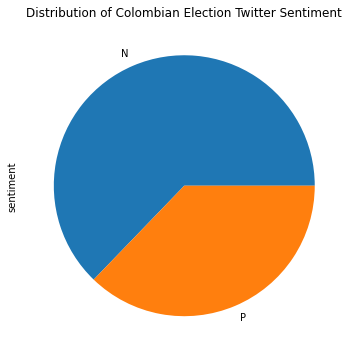

In [50]:
NB_results['sentiment'].value_counts().plot(kind='pie', title="Distribution of Colombian Election Twitter Sentiment", figsize=(6,6))

In [51]:
nb_class.show_most_informative_features(10)

Most Informative Features
            neg_r(felic) = 0.0                 P : N      =     30.5 : 1.0
             has(encant) = 1                   P : N      =     27.5 : 1.0
          has(graci,por) = 1                   P : N      =     27.5 : 1.0
           neg_r(encant) = 0.0                 P : N      =     27.5 : 1.0
           neg_l(encant) = 0.0                 P : N      =     26.5 : 1.0
           has(muy,buen) = 1                   P : N      =     23.5 : 1.0
          has(__HASH_FF) = 1                   P : N      =     20.9 : 1.0
        neg_l(__HASH_FF) = 0.0                 P : N      =     20.9 : 1.0
   emoji_(face-positive) = 'face-positive'      P : N      =     20.7 : 1.0
  has(graci,__PUNC_EXCL) = 1                   P : N      =     20.4 : 1.0


# Part 2 : Tweet Text Generation 

### Preprocess Specific Column for Training

In [52]:
#re-load the data
df = pd.read_csv('tweets_mentioning_candidates.csv')
df.head()

,tweetID,tweetText,urls,tweetRetweetCt,tweetFavoriteCt,tweetSource,tweetCreated,userID,userScreen,userName,userCreateDt,userDesc,userFollowerCt,userFriendsCt,userLocation,userTimezone
0,ID:1008504539916455936,Lo mejor del discurso de @IvanDuque es cuando ...,[],0,0,Twitter Web Client,2018-06-18 00:19:54,ID:533450497,Will_Perz,William PC,2012-03-22 20:05:30,NaN,29,234,NaN,NaN
1,ID:1008504538981191680,@manuelrosalesg @IvanDuque @mluciaramirez Los ...,[],0,0,Twitter for Android,2018-06-18 00:19:53,ID:1732923980,pablovillasmil1,Pablo L Villasmil,2013-09-05 19:44:21,"Tecnico Electronico, Opositor hasta la pata",172,412,"Maracaibo, Venezuela",NaN
2,ID:1008504538242977792,@gloserna @fransupelano @icolombianoo @AlvaroU...,[],0,0,Twitter for iPhone,2018-06-18 00:19:53,ID:965163103,carevalolc87,Christian Arevalo,2012-11-22 23:35:40,Empieza una nueva historia... cambio de trabaj...,54,88,NaN,NaN
3,ID:1008504536208683013,@_El_Patriota @petrogustavo @JSantrich_FARC Pa...,[],0,0,Twitter for Android,2018-06-18 00:19:53,ID:952356028263354368,de_gamin,Calentao De Gamín,2018-01-14 01:45:45,NaN,26,96,NaN,NaN
4,ID:1008504534371635201,Que diferencia de discursos! Gracias @IvanDuque,[],0,0,Twitter for iPhone,2018-06-18 00:19:52,ID:187162735,camiloparadag,Camilo Parada Gómez,2010-09-05 13:01:58,Ortopedista y Traumatólogo. Especialista en Ci...,1618,633,Bogotá - Colombia,NaN


In [53]:
#Data Cleaning
import re
def cleaning(s):
    s = str(s)
    s = s.lower()
    s = re.sub('\W,\s',' ',s)
    s = re.sub("\d+", "", s)
    s = re.sub('\s+',' ',s)
    s = re.sub('[!#$_]', '', s)
    s = re.sub('[^\\w\\.\\s\\-]+', '', s)
    s = s.replace("https","")
    s = s.replace(",","")
    s = s.replace("[\w*"," ")
    return s

#Extract the username
user_regex = re.compile(r"@(\w+)")
def user_repl(match):
	return '__user_'+match.group(1).upper()
#Replace Emojicons for one word
emoticons = \
	[	('__EMOT_SMILEY',	[':-)', ':)', '(:', '(-:', ] )	,\
		('__EMOT_LAUGH',		[':-D', ':D', 'X-D', 'XD', 'xD', ] )	,\
		('__EMOT_LOVE',		['<3', ':\*', ] )	,\
		('__EMOT_WINK',		[';-)', ';)', ';-D', ';D', '(;', '(-;', ] )	,\
		('__EMOT_FROWN',		[':-(', ':(', '(:', '(-:', ] )	,\
		('__EMOT_CRY',		[':,(', ':\'(', ':"(', ':(('] )	,\
	]
def escape_paren(arr):
	return [text.replace(')', '[)}\]]').replace('(', '[({\[]') for text in arr]
def regex_union(arr):
	return '(' + '|'.join( arr ) + ')'
emoticons_regex = [ (repl, re.compile(regex_union(escape_paren(regx))) ) for (repl, regx) in emoticons ]

In [54]:
df['tweetText'] = [re.sub(user_regex, user_repl, str(s)) for s in df['tweetText']]
df['tweetText'] = [re.sub(user_regex, user_repl, str(s)) for s in emoticons_regex and df['tweetText']]
df['tweetText'] = [cleaning(s) for s in df['tweetText']]

## Exploration

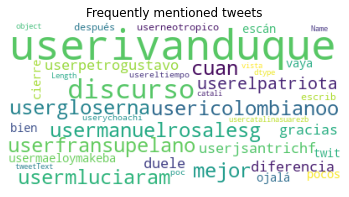

In [55]:
from nltk.corpus import stopwords
import string
punctuation = list(string.punctuation)
stop = stopwords.words('spanish') + punctuation + ['rt', 'via']
wordcloud = WordCloud(
                          background_color='white',
                          stopwords=stop,
                          max_words=150,
                          max_font_size=50, 
                          random_state=42
                         ).generate(str(df['tweetText']))
plt.imshow(wordcloud)
plt.rcParams["figure.figsize"] = (10,10)
plt.axis('off')
plt.title("Frequently mentioned tweets")
plt.show()

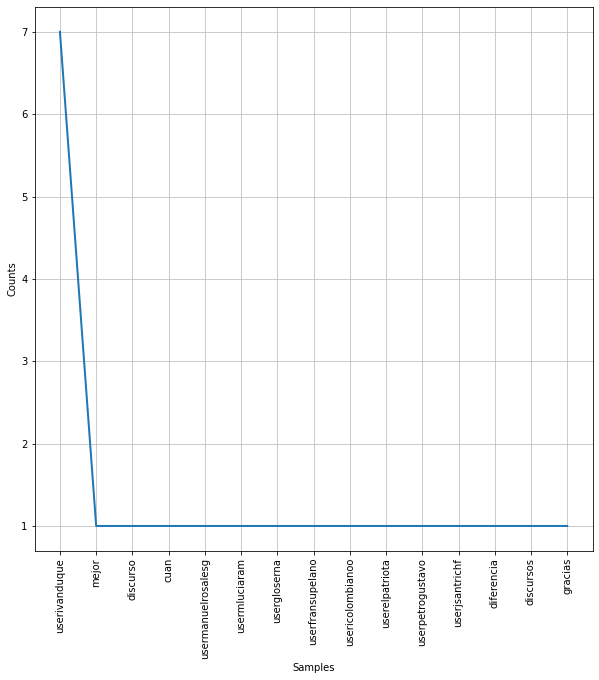

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [56]:
allWords = nltk.tokenize.word_tokenize(str(df['tweetText']))
allWordDist = nltk.FreqDist(w.lower() for w in allWords)
stopwords = nltk.corpus.stopwords.words('spanish')
allWordExceptStopDist = nltk.FreqDist(w.lower() for w in allWords if w not in stopwords and len(w) > 3)
allWordExceptStopDist.plot(15)

## Text Generation

In [57]:
# generate a sequence from the model
def generate_seq(model, tokenizer, seed_text, n_words):
	in_text, result = seed_text, seed_text
	for _ in range(n_words):
        
		encoded = tokenizer.texts_to_sequences([in_text])[0]
		encoded = array(encoded)
        
		yhat = model.predict_classes(encoded, verbose=0)
        
		out_word = ''
		for word, index in tokenizer.word_index.items():
			if index == yhat:
				out_word = word
				break
		in_text, result = out_word, result + ' ' + out_word
	return result

In [58]:
data = str(df['tweetText'])
tokenizer = Tokenizer()
tokenizer.fit_on_texts([data])
encoded = tokenizer.texts_to_sequences([data])[0] 

In [59]:
vocab_size = len(tokenizer.word_index) + 1 
print('Vocabulary Size: %d' % vocab_size)

sequences = list()
for i in range(1, len(encoded)):
	sequence = encoded[i-1:i+1]
	sequences.append(sequence)
print('Total Sequences: %d' % len(sequences))

sequences = array(sequences)
X, y = sequences[:,0],sequences[:,1]

Vocabulary Size: 58
Total Sequences: 67


In [60]:
from keras.layers import Dropout
y = to_categorical(y, num_classes=vocab_size)
# define model
model = Sequential()
model.add(Embedding(vocab_size, 10, input_length=1))
model.add(Dropout(0.1, input_shape=((468, 321))))
model.add(LSTM(50))
model.add(Dropout(0.1))
model.add(Dense(vocab_size, activation='softmax'))
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 1, 10)             580       
_________________________________________________________________
dropout (Dropout)            (None, 1, 10)             0         
_________________________________________________________________
lstm (LSTM)                  (None, 50)                12200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 58)                2958      
Total params: 15,738
Trainable params: 15,738
Non-trainable params: 0
_________________________________________________________________
None


In [61]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X, y, epochs=500, verbose=2)

Epoch 1/500
3/3 - 28s - loss: 4.0612 - accuracy: 0.0000e+00
Epoch 2/500
3/3 - 0s - loss: 4.0595 - accuracy: 0.0746
Epoch 3/500
3/3 - 0s - loss: 4.0582 - accuracy: 0.1045
Epoch 4/500
3/3 - 0s - loss: 4.0569 - accuracy: 0.1045
Epoch 5/500
3/3 - 0s - loss: 4.0559 - accuracy: 0.1045
Epoch 6/500
3/3 - 0s - loss: 4.0547 - accuracy: 0.1194
Epoch 7/500
3/3 - 0s - loss: 4.0536 - accuracy: 0.1045
Epoch 8/500
3/3 - 0s - loss: 4.0522 - accuracy: 0.1045
Epoch 9/500
3/3 - 0s - loss: 4.0513 - accuracy: 0.1045
Epoch 10/500
3/3 - 0s - loss: 4.0503 - accuracy: 0.1045
Epoch 11/500
3/3 - 0s - loss: 4.0490 - accuracy: 0.1045
Epoch 12/500
3/3 - 0s - loss: 4.0473 - accuracy: 0.1045
Epoch 13/500
3/3 - 0s - loss: 4.0462 - accuracy: 0.1045
Epoch 14/500
3/3 - 0s - loss: 4.0452 - accuracy: 0.1045
Epoch 15/500
3/3 - 0s - loss: 4.0440 - accuracy: 0.1045
Epoch 16/500
3/3 - 0s - loss: 4.0425 - accuracy: 0.1045
Epoch 17/500
3/3 - 0s - loss: 4.0409 - accuracy: 0.1045
Epoch 18/500
3/3 - 0s - loss: 4.0396 - accuracy: 0.1

Epoch 147/500
3/3 - 0s - loss: 2.5852 - accuracy: 0.3881
Epoch 148/500
3/3 - 0s - loss: 2.5997 - accuracy: 0.4179
Epoch 149/500
3/3 - 0s - loss: 2.5441 - accuracy: 0.4328
Epoch 150/500
3/3 - 0s - loss: 2.5299 - accuracy: 0.4478
Epoch 151/500
3/3 - 0s - loss: 2.5773 - accuracy: 0.4776
Epoch 152/500
3/3 - 0s - loss: 2.5336 - accuracy: 0.4030
Epoch 153/500
3/3 - 0s - loss: 2.4972 - accuracy: 0.4627
Epoch 154/500
3/3 - 0s - loss: 2.5053 - accuracy: 0.3731
Epoch 155/500
3/3 - 0s - loss: 2.4974 - accuracy: 0.4478
Epoch 156/500
3/3 - 0s - loss: 2.4349 - accuracy: 0.5075
Epoch 157/500
3/3 - 0s - loss: 2.4595 - accuracy: 0.5075
Epoch 158/500
3/3 - 0s - loss: 2.4209 - accuracy: 0.5522
Epoch 159/500
3/3 - 0s - loss: 2.4370 - accuracy: 0.4627
Epoch 160/500
3/3 - 0s - loss: 2.3940 - accuracy: 0.4627
Epoch 161/500
3/3 - 0s - loss: 2.4289 - accuracy: 0.4925
Epoch 162/500
3/3 - 0s - loss: 2.4104 - accuracy: 0.4478
Epoch 163/500
3/3 - 0s - loss: 2.3744 - accuracy: 0.5522
Epoch 164/500
3/3 - 0s - loss: 

Epoch 291/500
3/3 - 0s - loss: 1.1810 - accuracy: 0.7612
Epoch 292/500
3/3 - 0s - loss: 1.1041 - accuracy: 0.8358
Epoch 293/500
3/3 - 0s - loss: 1.1432 - accuracy: 0.7612
Epoch 294/500
3/3 - 0s - loss: 1.1598 - accuracy: 0.7612
Epoch 295/500
3/3 - 0s - loss: 1.1186 - accuracy: 0.7910
Epoch 296/500
3/3 - 0s - loss: 1.0725 - accuracy: 0.7612
Epoch 297/500
3/3 - 0s - loss: 1.1115 - accuracy: 0.7015
Epoch 298/500
3/3 - 0s - loss: 1.1280 - accuracy: 0.7761
Epoch 299/500
3/3 - 0s - loss: 1.0921 - accuracy: 0.7463
Epoch 300/500
3/3 - 0s - loss: 1.1101 - accuracy: 0.7761
Epoch 301/500
3/3 - 0s - loss: 1.1333 - accuracy: 0.7463
Epoch 302/500
3/3 - 0s - loss: 1.0908 - accuracy: 0.7910
Epoch 303/500
3/3 - 0s - loss: 1.0884 - accuracy: 0.7910
Epoch 304/500
3/3 - 0s - loss: 1.1100 - accuracy: 0.7463
Epoch 305/500
3/3 - 0s - loss: 1.0646 - accuracy: 0.7612
Epoch 306/500
3/3 - 0s - loss: 1.1102 - accuracy: 0.7910
Epoch 307/500
3/3 - 0s - loss: 1.1157 - accuracy: 0.7463
Epoch 308/500
3/3 - 0s - loss: 

Epoch 435/500
3/3 - 0s - loss: 0.7339 - accuracy: 0.7761
Epoch 436/500
3/3 - 0s - loss: 0.6370 - accuracy: 0.8358
Epoch 437/500
3/3 - 0s - loss: 0.6900 - accuracy: 0.8209
Epoch 438/500
3/3 - 0s - loss: 0.6714 - accuracy: 0.8209
Epoch 439/500
3/3 - 0s - loss: 0.6734 - accuracy: 0.7761
Epoch 440/500
3/3 - 0s - loss: 0.6598 - accuracy: 0.8060
Epoch 441/500
3/3 - 0s - loss: 0.6958 - accuracy: 0.8358
Epoch 442/500
3/3 - 0s - loss: 0.6954 - accuracy: 0.8060
Epoch 443/500
3/3 - 0s - loss: 0.6317 - accuracy: 0.8209
Epoch 444/500
3/3 - 0s - loss: 0.6832 - accuracy: 0.7761
Epoch 445/500
3/3 - 0s - loss: 0.6634 - accuracy: 0.7910
Epoch 446/500
3/3 - 0s - loss: 0.6599 - accuracy: 0.8209
Epoch 447/500
3/3 - 0s - loss: 0.6671 - accuracy: 0.8657
Epoch 448/500
3/3 - 0s - loss: 0.6556 - accuracy: 0.7910
Epoch 449/500
3/3 - 0s - loss: 0.7016 - accuracy: 0.8209
Epoch 450/500
3/3 - 0s - loss: 0.6558 - accuracy: 0.8209
Epoch 451/500
3/3 - 0s - loss: 0.6257 - accuracy: 0.8358
Epoch 452/500
3/3 - 0s - loss: 

**Accuracy is not so high but enough for our purposes!**

# Generate my text !

In [62]:
allWordExceptStopDist.most_common(10)

[('userivanduque', 7),
 ('mejor', 1),
 ('discurso', 1),
 ('cuan', 1),
 ('usermanuelrosalesg', 1),
 ('usermluciaram', 1),
 ('usergloserna', 1),
 ('userfransupelano', 1),
 ('usericolombianoo', 1),
 ('userelpatriota', 1)]

In [ ]:
string = input("What do you want to test? ")
print(generate_seq(model, tokenizer, string , 5)) #give me 5 words in a sequence